# Southern Africa - Topography and bathymetry

A 0.1 degrees resolution grid of topography over Southern Africa referenced to
mean sea-level.

**Source:** [ETOPO1](https://doi.org/10.7289/V5C8276M) (grid generated by the [ICGEM calculation service](http://icgem.gfz-potsdam.de/home))

**License:** [CC-BY](https://creativecommons.org/licenses/by/4.0/)

## Notes

This notebook loads the grid from the text file, sets proper CF-compliant metadata, and saves it to compressed netCDF for a smaller file size (requires the netcdf4 library for loading). Coordinates are referenced to WGS84.

In [1]:
import os
import lzma
from pathlib import Path
import matplotlib.pyplot as plt
import pygmt
import xarray as xr
import numpy as np
import harmonica as hm
import pooch

## Read the data

Use Harmonica to read the data.

In [2]:
with lzma.open(Path("raw") / "etopo1-shm-southern-africa-topography.gdf.xz", "rt") as f:
    data_raw = hm.load_icgem_gdf(f, dtype="float32")
icgem_metadata = data_raw.attrs.copy()
data = data_raw.topography_shm.rename("topography")
data

<xarray.DataArray 'topography' (latitude: 171, longitude: 211)>
array([[-4889.503  , -4863.1963 , -4860.9136 , ..., -2977.9358 ,
        -2530.0027 , -2480.624  ],
       [-4893.6675 , -4862.786  , -4827.987  , ..., -2762.1653 ,
        -2871.5815 , -2778.3086 ],
       [-4894.563  , -4873.149  , -4831.4224 , ..., -2396.1055 ,
        -2429.4414 , -2416.8313 ],
       ...,
       [   71.48269,   269.6431 ,   422.26022, ...,  2053.3633 ,
         1710.3624 ,  1278.496  ],
       [  154.67157,   418.39258,   583.0382 , ...,  1958.3533 ,
         1336.932  ,  1232.5173 ],
       [  289.06653,   464.62985,   702.856  , ...,  1756.3916 ,
         1072.9773 ,  1389.9989 ]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 12.0 12.1 12.2 12.3 ... 32.7 32.8 32.9 33.0
  * latitude   (latitude) float32 -35.0 -34.9 -34.8 -34.7 ... -18.2 -18.1 -18.0

## Fix grid coordinates

Coordinates are slightly imprecise since ICGEM uses something like `np.arange` to generate them instead of `np.linspace`, which is more precise and the correct way to do it. This means that the spacing is not exactly constant, which can mess up plotting with PyGMT later on. Fix this by assigning adjusted coordinates. This shouldn't make a difference quantitatively since changes are in the order of 1e-5 or below.


In [3]:
longitude = np.linspace(12, 33, data.longitude.size)
latitude = np.linspace(-35, -18, data.latitude.size)

data = data.assign_coords(longitude=longitude, latitude=latitude)
data

<xarray.DataArray 'topography' (latitude: 171, longitude: 211)>
array([[-4889.503  , -4863.1963 , -4860.9136 , ..., -2977.9358 ,
        -2530.0027 , -2480.624  ],
       [-4893.6675 , -4862.786  , -4827.987  , ..., -2762.1653 ,
        -2871.5815 , -2778.3086 ],
       [-4894.563  , -4873.149  , -4831.4224 , ..., -2396.1055 ,
        -2429.4414 , -2416.8313 ],
       ...,
       [   71.48269,   269.6431 ,   422.26022, ...,  2053.3633 ,
         1710.3624 ,  1278.496  ],
       [  154.67157,   418.39258,   583.0382 , ...,  1958.3533 ,
         1336.932  ,  1232.5173 ],
       [  289.06653,   464.62985,   702.856  , ...,  1756.3916 ,
         1072.9773 ,  1389.9989 ]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 12.0 12.1 12.2 12.3 ... 32.7 32.8 32.9 33.0
  * latitude   (latitude) float64 -35.0 -34.9 -34.8 -34.7 ... -18.2 -18.1 -18.0

## Set proper metadata

Add proper metadata following CF-conventions to all `DataArray`s and the `Dataset` as a whole.


In [4]:
def minmax_round(grid, decimals):
    """
    Return the minimum and maximum values in the grid 
    rounded to *decimal* places.
    """
    vmin = np.round(grid.values.min(), decimals=decimals)
    vmax = np.round(grid.values.max(), decimals=decimals)
    return (vmin, vmax)

In [5]:
data.attrs = {
    "Conventions": "CF-1.8",
    "title": "Topographic and bathymetric height for Southern Africa obtained from ETOPO1 (ice surface) at 0.1 degrees resolution",
    "crs": "WGS84",
    "source": "Generated from a spherical harmonic model by the ICGEM Calculation Service (http://icgem.gfz-potsdam.de)",
    "license": "public domain",
    "references": "https://doi.org/10.7289/V5C8276M",
    "long_name": "topographic height above mean sea level",
    "standard_name": "height_above_mean_sea_level",
    "description": "height topography/bathymetry referenced to mean sea level",
    "units": "m",
    "actual_range": minmax_round(data, decimals=0),
    "icgem_metadata": "\n".join([f"{k}: {v}" for k,v in icgem_metadata.items()]),
}
data.longitude.attrs = {
    "long_name": "longitude",
    "standard_name": "longitude",
    "units": "degrees_east",
    "actual_range": (data.longitude.values.min(), data.longitude.values.max()),
}
data.latitude.attrs = {
    "long_name": "latitude",
    "standard_name": "latitude",
    "units": "degrees_north",
    "actual_range": (data.latitude.values.min(), data.latitude.values.max()),
}
data

<xarray.DataArray 'topography' (latitude: 171, longitude: 211)>
array([[-4889.503  , -4863.1963 , -4860.9136 , ..., -2977.9358 ,
        -2530.0027 , -2480.624  ],
       [-4893.6675 , -4862.786  , -4827.987  , ..., -2762.1653 ,
        -2871.5815 , -2778.3086 ],
       [-4894.563  , -4873.149  , -4831.4224 , ..., -2396.1055 ,
        -2429.4414 , -2416.8313 ],
       ...,
       [   71.48269,   269.6431 ,   422.26022, ...,  2053.3633 ,
         1710.3624 ,  1278.496  ],
       [  154.67157,   418.39258,   583.0382 , ...,  1958.3533 ,
         1336.932  ,  1232.5173 ],
       [  289.06653,   464.62985,   702.856  , ...,  1756.3916 ,
         1072.9773 ,  1389.9989 ]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 12.0 12.1 12.2 12.3 ... 32.7 32.8 32.9 33.0
  * latitude   (latitude) float64 -35.0 -34.9 -34.8 -34.7 ... -18.2 -18.1 -18.0
Attributes:
    Conventions:     CF-1.8
    title:           Topographic and bathymetric height for Southern Africa o...
    crs:             WGS84
    source:          Generated from a spherical harmonic model by the ICGEM C...
    license:         public domain
    references:      https://doi.org/10.7289/V5C8276M
    long_name:       topographic height above mean sea level
    standard_name:   height_above_mean_sea_level
    description:     height topography/bathymetry referenced to mean sea level
    units:           m
    actual_range:    (-4970.0, 3270.0)
    icgem_metadata:  generating_institute: gfz-potsdam\ngenerating_date: 2022...

## Plot the data 

Make a quick plot to make sure the data look OK. This plot will be used as a preview of the dataset.

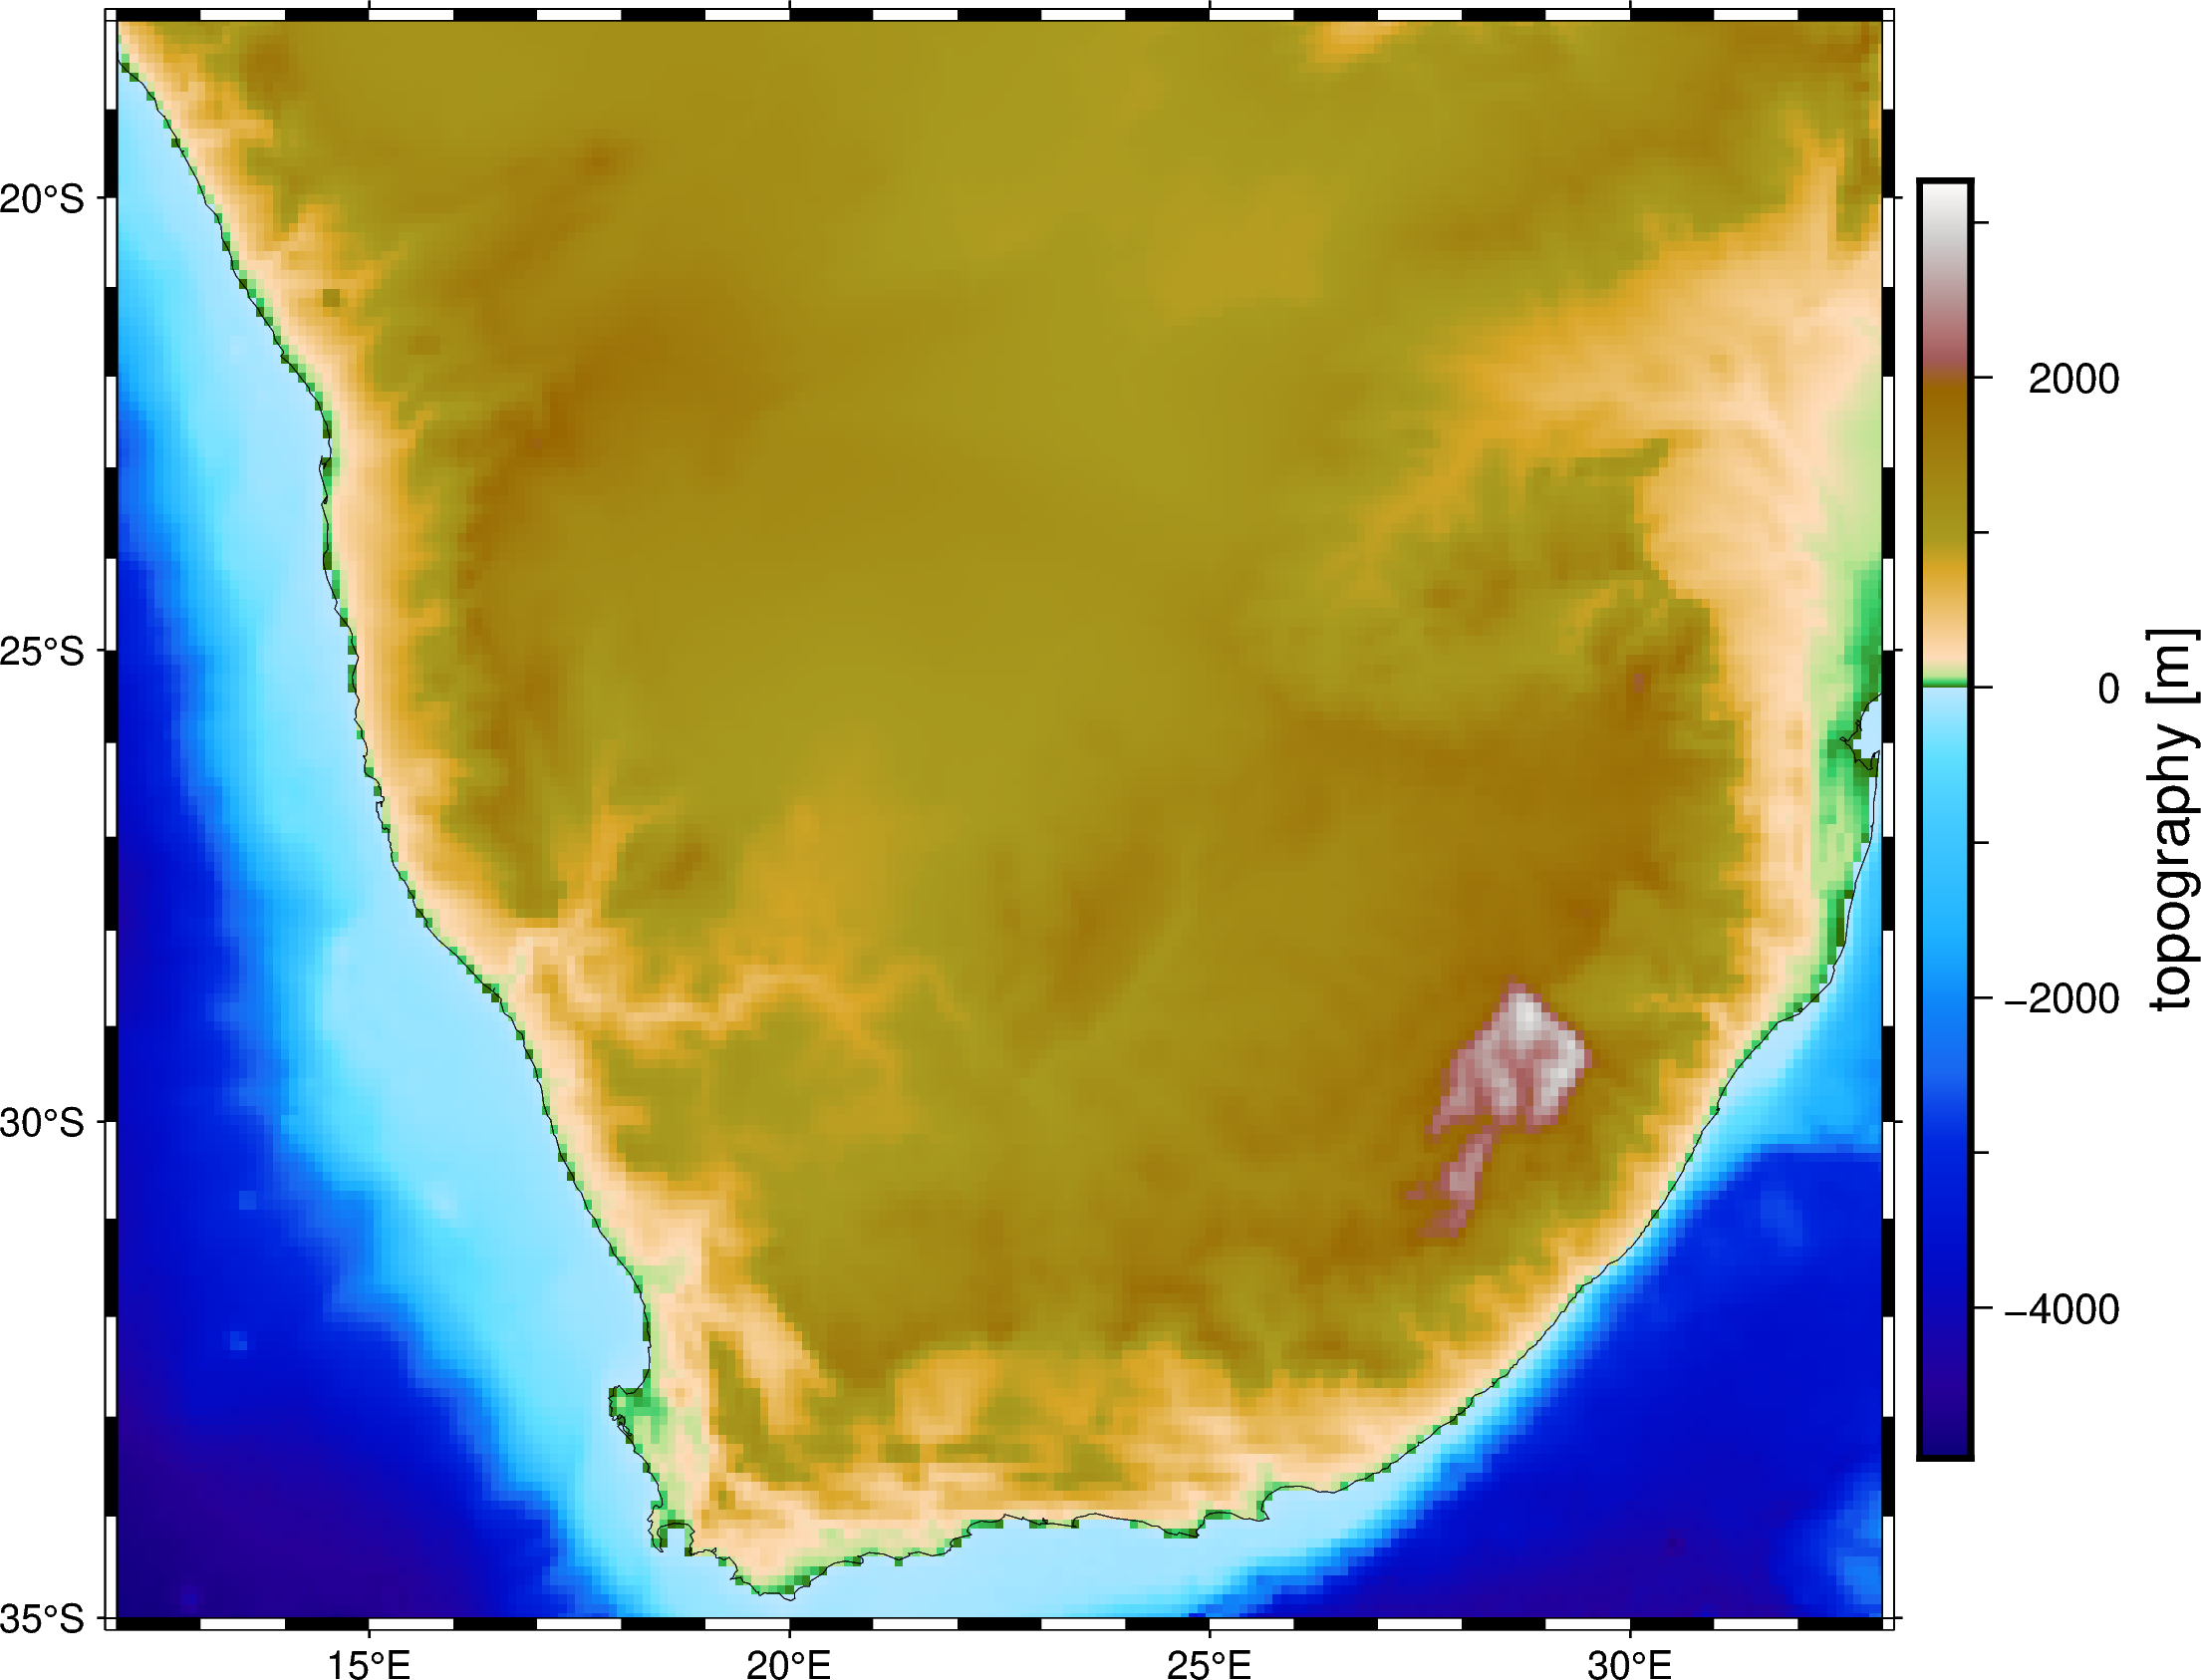

In [6]:
fig = pygmt.Figure()
fig.grdimage(data, cmap="etopo1", projection="M15c")
fig.colorbar(frame='af+l"topography [m]"', position="JCR")
fig.basemap(frame=True)
fig.coast(shorelines="0.1p", area_thresh=1e4)
fig.savefig("preview.jpg", dpi=200)
fig.show()

## Export

Save the grid to a netCDF file and calculate the size and MD5/SHA256 hashes.

Use compression (both zlib and discretization based) to reduce the file sizes. The scale_factor determines the amount of decimal places retained when converting floats into integers. See http://xarray.pydata.org/en/stable/user-guide/io.html#writing-encoded-datadata_reloaded = xr.load_dataarray(output)
data_reloaded


In [7]:
output = "southern-africa-topography.nc"
data.to_netcdf(
    output, 
    format="NETCDF4",
    encoding={
        'topography': {
            "zlib": True, 
            'dtype': 'int32', 
            'scale_factor': 0.01, 
            '_FillValue': 32000, 
            'add_offset': 0,
        },
    }
)
print(f"file: {output}")
print(f"size: {os.path.getsize(output) / 1e6} Mb")
for alg in ["md5", "sha256"]:
    print(f"{alg}:{pooch.file_hash(output, alg=alg)}")

file: southern-africa-topography.nc
size: 0.099919 Mb
md5:c260aa074e2d34ca75aeca07c8740e5a
sha256:851cfd47638d2693f703ecea20e86a7227923494816c8f293143753cc9523301


## Read back the data and plot it

Verify that the output didn't corrupt anything.

In [8]:
data_reloaded = xr.load_dataarray(output)
data_reloaded

<xarray.DataArray 'topography' (latitude: 171, longitude: 211)>
array([[-4889.5 , -4863.2 , -4860.91, ..., -2977.94, -2530.  , -2480.62],
       [-4893.67, -4862.79, -4827.99, ..., -2762.17, -2871.58, -2778.31],
       [-4894.56, -4873.15, -4831.42, ..., -2396.11, -2429.44, -2416.83],
       ...,
       [   71.48,   269.64,   422.26, ...,  2053.36,  1710.36,  1278.5 ],
       [  154.67,   418.39,   583.04, ...,  1958.35,  1336.93,  1232.52],
       [  289.07,   464.63,   702.86, ...,  1756.39,  1072.98,  1390.  ]])
Coordinates:
  * longitude  (longitude) float64 12.0 12.1 12.2 12.3 ... 32.7 32.8 32.9 33.0
  * latitude   (latitude) float64 -35.0 -34.9 -34.8 -34.7 ... -18.2 -18.1 -18.0
Attributes:
    Conventions:     CF-1.8
    title:           Topographic and bathymetric height for Southern Africa o...
    crs:             WGS84
    source:          Generated from a spherical harmonic model by the ICGEM C...
    license:         public domain
    references:      https://doi.org/10.7289/V5C8276M
    long_name:       topographic height above mean sea level
    standard_name:   height_above_mean_sea_level
    description:     height topography/bathymetry referenced to mean sea level
    units:           m
    actual_range:    [-4970.  3270.]
    icgem_metadata:  generating_institute: gfz-potsdam\ngenerating_date: 2022...

Make the figure again but don't save it to a file this time.

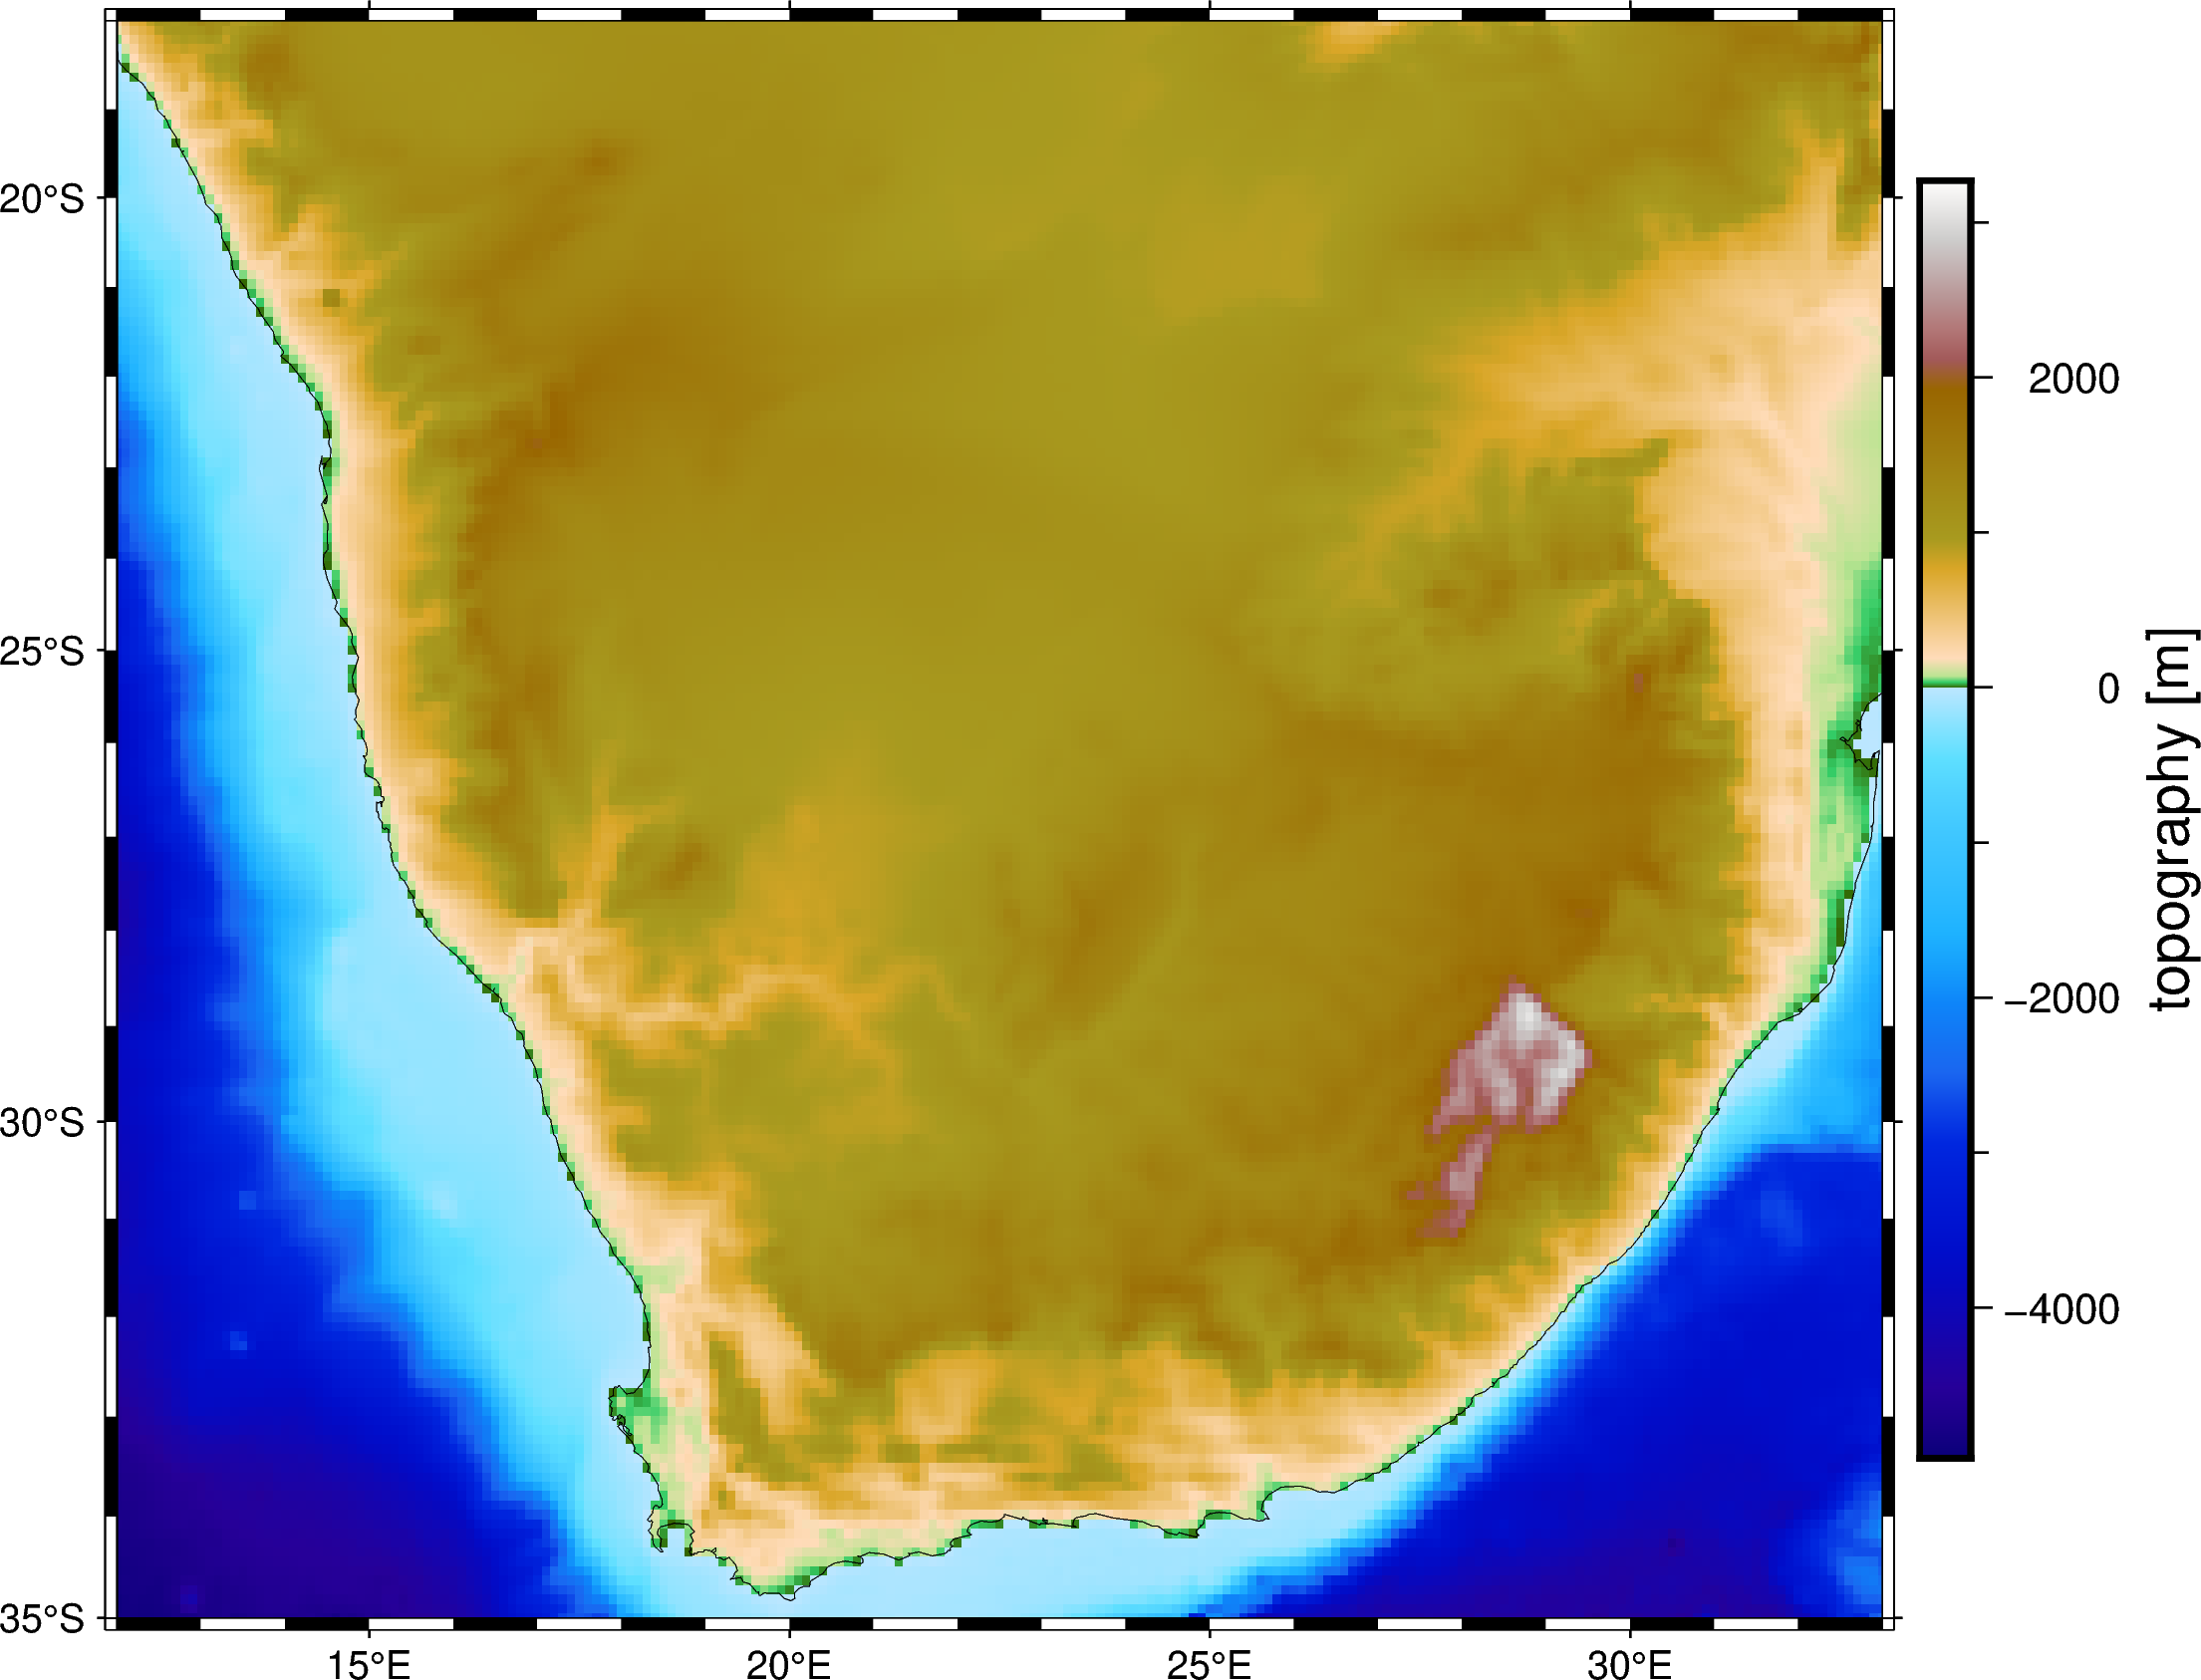

In [9]:
fig = pygmt.Figure()
fig.grdimage(data_reloaded, cmap="etopo1", projection="M15c")
fig.colorbar(frame='af+l"topography [m]"', position="JCR")
fig.basemap(frame=True)
fig.coast(shorelines="0.1p", area_thresh=1e4)
fig.show()